# Chatper 15. Natural Language Processing - Pretraining

In [1]:
!pip install -U torch==2.0.0 torchvision==0.15.1
!pip install -U d2l==1.0.3

  Using cached torch-2.0.0-cp310-cp310-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached torchvision-0.15.1-cp310-cp310-manylinux1_x86_64.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_cupti_cu11-11.7.101-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu11-10.9.0.58-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu11-10.2.10.91-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu11-11.4.0.1-2-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu11-11.7.4.91-py3-none-manylinux1_x86_64.whl.m

Using cached d2l-1.0.3-py3-none-any.whl (111 kB)
Using cached matplotlib-3.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
Using cached pandas-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
Using cached scipy-1.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pandas
    Found existi

## Chapter 15.1 Word Embedding (word2vec)

* Word vectors are vectors used to represent words, and can also be considered as feature vectors or representations of words. The technique of mapping words to real vectors is called word embedding.

* The word2vec tool contains both the skip-gram and continuous bag of words models.

* The skip-gram model assumes that a word can be used to generate its surrounding words in a text sequence; while the continuous bag of words model assumes that a center word is generated based on its surrounding context words.

## Chapter 15.2 Approximate Training

* Negative sampling constructs the loss function by considering mutually independent events that involve both positive and negative examples. The computational cost for training is linearly dependent on the number of noise words at each step.

* Hierarchical softmax constructs the loss function using the path from the root node to the leaf node in the binary tree. The computational cost for training is dependent on the logarithm of the dictionary size at each step.


## Chatper 15.3 The Dataset for Pretraining Word Embeddings

In [2]:
import collections
import math
import os
import random
import torch
from d2l import torch as d2l

In [3]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip', 
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    
    data_dir = d2l.download_extract('ptb')
    
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

In [4]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

In [6]:
def subsample(sentences, vocab):
    """Subsample high-frequency words."""
    
    # Exclude unknown tokens ('<unk>')
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                for line in sentences]
    
    counter = collections.Counter([
        token for line in sentences for token in line
    ])
    
    num_tokens = sum(counter.values())
    
    
    # Return True if token is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) < 
              math.sqrt(1e-4 / counter[token] * num_tokens))
    
    return ([[token for token in line if keep(token)] for line in sentences], counter)

subsampled, counter = subsample(sentences, vocab)

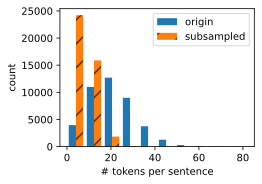

In [7]:
d2l.show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence', 
                           'count', sentences, subsampled);

In [9]:
def compare_counts(token):
    return (f'# of "{token}": '
           f'before={sum([l.count(token) for l in sentences])}, '
           f'after={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'# of "the": before=50770, after=2069'

In [10]:
compare_counts('join')

'# of "join": before=45, after=45'

In [11]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [3228, 710, 1773], [3178, 993, 3922, 1922, 4743, 2696]]

In [12]:
# Extracting Center Words and Contxt Words

In [13]:
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-garm."""
    
    centers, contexts = [], []
    for line in corpus:
        
        if len(line) < 2:
            continue
        centers += line
    
        for i in range(len(line)):
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size), 
                            min(len(line), i + 1 + window_size)))
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts


In [14]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2]
center 2 has contexts [1, 3]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [3, 5]
center 5 has contexts [3, 4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [8]


In [15]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 1501554'

In [18]:
# 15.3.4 Negative Sampling

class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    
    def __init__(self, sampling_weights):
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0
        
    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        
        return self.candidates[self.i - 1]

In [19]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[1, 2, 1, 3, 3, 3, 1, 3, 2, 3]

In [20]:
def get_negatives(all_contexts, vocab, counter, K):
    """Return noise words in negative sampling."""
    
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                           for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            if neg not in contexts:
                negatives.append(neg)
                
        all_negatives.append(negatives)
        
    return all_negatives

In [23]:
def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(contexts_negatives),
           torch.tensor(masks), torch.tensor(labels))

In [24]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']

for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [26]:
# put it all together

def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """Download the PTB dataset and then load it into memory."""
    
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)
    
    
    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives
            
        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index], self.negatives[index])
        
        def __len__(self):
            return len(self.centers)
        
    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    
    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, 
                                            collate_fn=batchify,
                                           num_workers=num_workers)
    
    return data_iter, vocab

In [27]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
        
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


* High-frequency words may not be so useful in training. We can subsample them for speedup in training.
* For computational efficiency, we load examples in minibatches. We can define other variables to distinguish paddings from non-paddings, and positive examples from negative ones.

## Chapter 15.4 Pretraining word2vec

In [28]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [29]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words)

In [30]:
# The Skip-Gram Model

In [32]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
     f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [33]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[ 1.1282, -0.2104, -1.3216,  0.4277],
         [-1.3235, -0.4826, -0.2026,  1.0852],
         [-0.0623,  1.4778, -0.1673, -0.7602]],

        [[ 0.0686,  1.2438,  0.6493,  0.2997],
         [ 1.0367, -0.1361, -0.3252,  0.7635],
         [-1.7689, -0.3485,  1.0522, -0.1217]]], grad_fn=<EmbeddingBackward0>)

In [34]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [35]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [36]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        
        return out.mean(dim=1)
    
loss = SigmoidBCELoss()

In [37]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [39]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


In [40]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                embedding_dim=embed_size),
                   nn.Embedding(num_embeddings=len(vocab),
                               embedding_dim=embed_size))

In [45]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs])
    
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch
            ]
            
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask) / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
         f'{metric[1] / timer.stop():.1f} tokens/sec on {str(deivce)}')

NameError: name 'deivce' is not defined

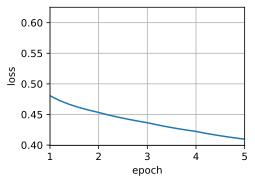

In [46]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

In [47]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    
    for i in topk[1:]:
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')
        
get_similar_tokens('chip', 3, net[0])

cosine sim=0.692: microprocessor
cosine sim=0.650: intel
cosine sim=0.594: chips


* We can train a skip-gram model with negative sampling using embedding layers and the binary cross-entropy loss.

* Applications of word embeddings include finding semantically similar words for a given word based on the cosine similarity of word vectors.

## Chapter 15.5 Word Embedding with Global Vectors(GloVe)

* The skip-gram model can be interpreted using global corpus statistics such as word-word co-occurrence counts.

* The cross-entropy loss may not be a good choice for measuring the difference of two probability distributions, especially for a large corpus. GloVe uses squared loss to fit precomputed global corpus statistics.

* The center word vector and the context word vector are mathematically equivalent for any word in GloVe.

* GloVe can be interpreted from the ratio of word-word co-occurrence probabilities.

## Chapter 15.6 Subword Embedding

In [48]:
import collections

symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
          '_', '[UNK]']

In [49]:
raw_token_freqs = {'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4}
token_freqs = {}

for token, freq in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token]
    
token_freqs

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

In [50]:
def get_max_freq_pair(token_freqs):
    pairs = collections.defaultdict(int)
    for token, freq in token_freqs.items():
        symbols = token.split()
        for i in range(len(symbols) - 1):
            # Key of 'pairs' is a tuple of two consecutive symbols
            pairs[symbols[i], symbols[i + 1]] += freq
    return max(pairs, key=pairs.get)

In [51]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair), ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
        
    return new_token_freqs

In [52]:
num_merges = 10
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'merge #{i + 1}:', max_freq_pair)

merge #1: ('t', 'a')
merge #2: ('ta', 'l')
merge #3: ('tal', 'l')
merge #4: ('f', 'a')
merge #5: ('fa', 's')
merge #6: ('fas', 't')
merge #7: ('e', 'r')
merge #8: ('er', '_')
merge #9: ('tall', '_')
merge #10: ('fast', '_')


In [53]:
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


In [54]:
print(list(token_freqs.keys()))

['fast_', 'fast er_', 'tall_', 'tall er_']


In [55]:
def segment_BPE(tokens, symbols):
    outputs = []
    
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        
        while start < len(token) and start < end:
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                start = end
                end = len(token)
            else:
                end -= 1
                
        if start < len(token):
            cur_output.append('[UNK]')
        outputs.append(' '.join(cur_output))
    return outputs

In [56]:
tokens = ['tallest_', 'fatter_']
print(segment_BPE(tokens, symbols))

['tall e s t _', 'fa t t er_']


* The fastText model proposes a subword embedding approach. Based on the skip-gram model in word2vec, it represents a center word as the sum of its subword vectors.

* Byte pair encoding performs a statistical analysis of the training dataset to discover common symbols within a word. As a greedy approach, byte pair encoding iteratively merges the most frequent pair of consecutive symbols.

* Subword embedding may improve the quality of representations of rare words and out-of-dictionary words.

## Chapter 15.7 Word Similarity and Analogy

In [58]:
import os
import torch
from torch import nn
from d2l import torch as d2l